In [1]:
import sys
sys.path.append('../')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import logging

import utils.simulation2d as project
data_dir = "../local_data/re100/"

In [2]:
(ux,uy,pp) = project.read_data(data_dir,idx_body=132)
# take base measurement
pb = project.take_measurement_base(pp, ly=[1.5,2.5] ,centrex=0, domain_y=4)

In [3]:
probe_location = (300,50)
probe_ux = ux[:,probe_location[0],probe_location[1]]
probe_uy = uy[:,probe_location[0],probe_location[1]]
probe_p = pb[:,probe_location[1]-49]

dt = 0.0002*480
freq = np.fft.fftfreq(len(probe_ux),d=dt)
f_ux = np.fft.fft(probe_ux-np.mean(probe_ux))/len(probe_ux)
f_uy = np.fft.fft(probe_uy-np.mean(probe_uy))/len(probe_uy)
f_p = np.fft.fft(probe_p-np.mean(probe_p))/len(probe_p)

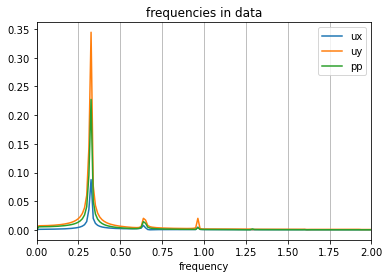

highest peak at  0.32552083333333337  Hz.


In [4]:
plt.figure()
plt.plot(freq[:int(len(freq)/2)],np.abs(f_ux)[:int(len(freq)/2)],label ='ux')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_uy)[:int(len(freq)/2)],label ='uy')
plt.plot(freq[:int(len(freq)/2)],np.abs(f_p)[:int(len(freq)/2)],label ='pp')
plt.title('frequencies in data')
plt.xlabel('frequency')
plt.xlabel('frequency')
plt.xlim([0,2])
plt.legend()
plt.grid(True, which='both', axis='x')
plt.show()
idx_sort = np.argsort(f_uy)
high_freq = freq[idx_sort][-1]
print("highest peak at ", high_freq, " Hz.")

In [5]:
amp = np.abs(f_uy[idx_sort][-1])
phase = np.angle(f_uy[idx_sort][-1])

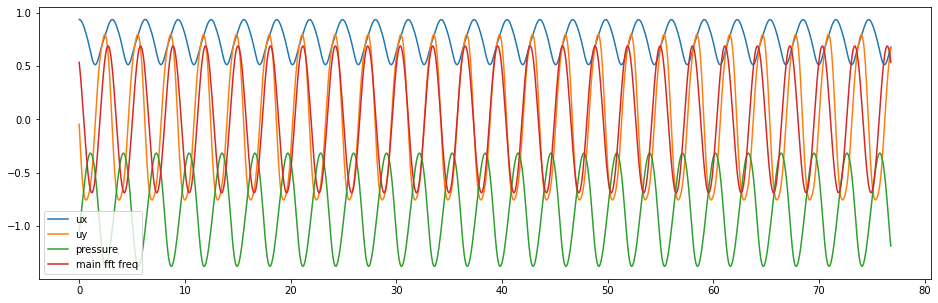

In [6]:
t = np.linspace(0,probe_ux.shape[0]*dt,probe_ux.shape[0])
plt.figure(figsize=(16,5))
plt.plot(t,probe_ux,label='ux')
plt.plot(t,probe_uy,label='uy')
plt.plot(t,probe_p,label='pressure')
plt.plot(t,2*amp*np.cos(high_freq*2*np.pi*t+phase),label='main fft freq')
plt.legend()
# plt.xlim([0,20])
plt.show()

# Vorticity

In [7]:
import h5py 
with h5py.File(data_dir+'vort.h5','r') as hf:
    vort = np.array(hf.get('vort'))
vort.shape

(800, 513, 129)

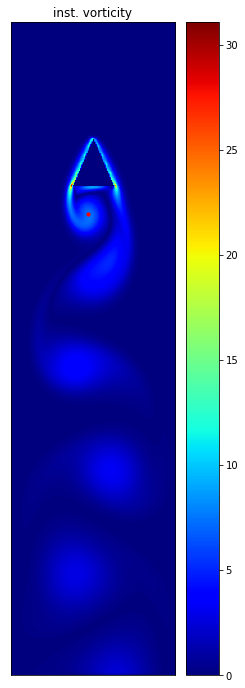

In [11]:
plt.figure(figsize=(4,12))
plt.title('inst. vorticity')
plt.imshow(vort[0,...],'jet')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.scatter(60,150,s=10,c='r')
plt.show()

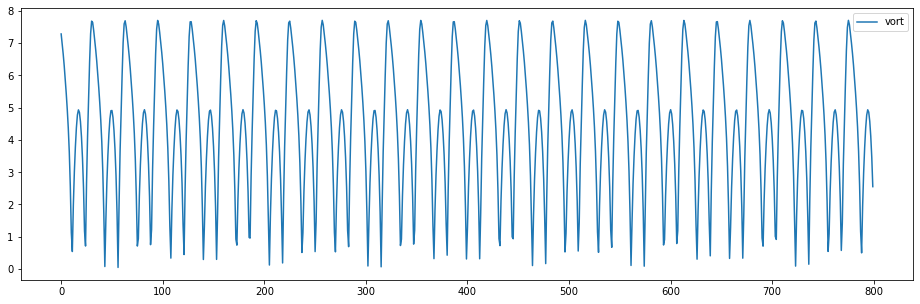

In [12]:
probe_vort = vort[:,150,60]
plt.figure(figsize=(16,5))
plt.plot(probe_vort,label='vort')
plt.legend()
plt.show()
